### Step 5: Higher-Dim Embeddings: 
Use R9 for 3x3 grids (flatten to [9 elements]); embed with a learned autoencoder (e.g., Keras) to preserve spatial structure. Project to R3 for vis, but compute geodesics in R9 (extend eqs to 9 dims, e.g., d2x1 to d2x9 with M pull to target)

Epoch 0: Loss = 0.1052
Epoch 10: Loss = 0.1042
Epoch 20: Loss = 0.1033
Epoch 30: Loss = 0.1026
Epoch 40: Loss = 0.1018
Warped Manifold Converged to Target: True
Final Position (Well): [7.00484261 4.00658851 1.00101602 8.0029614  5.01147087 2.00129393
 9.00323931 6.00240558 3.01741887]
Target Position: [7. 4. 1. 8. 5. 2. 9. 6. 3.]


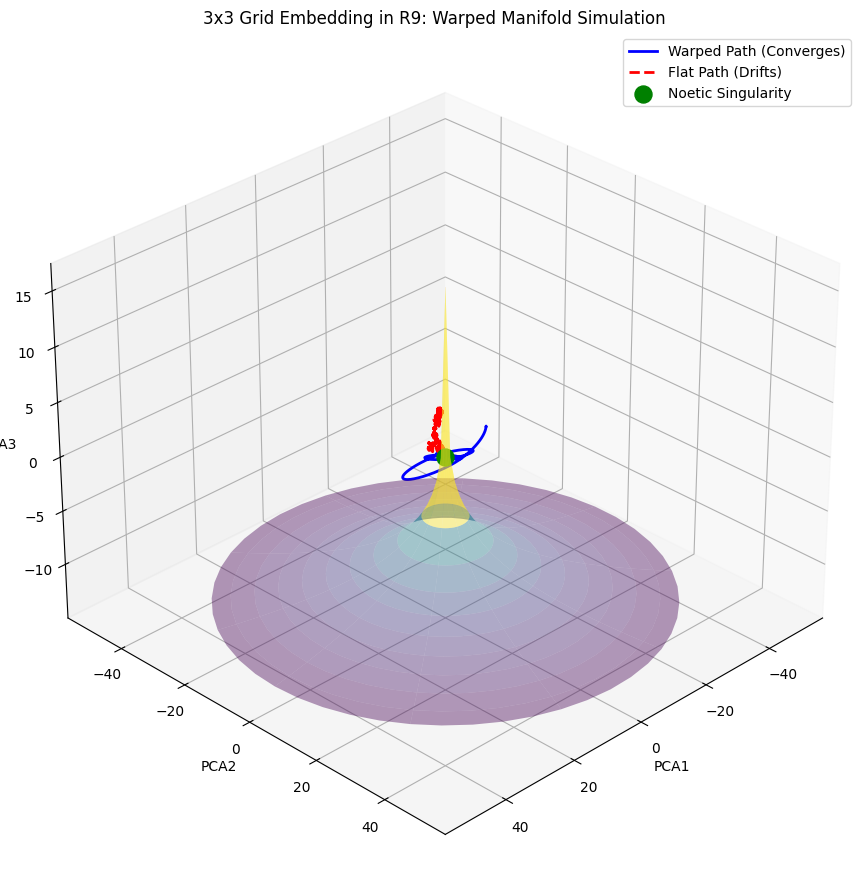

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

# Step 5: Higher-Dim Embeddings for 3x3 Grid
def create_arc_data_3x3():
    # Sample 3x3 grid flattened to R9
    input_r9 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])  # Initial [1 2 3; 4 5 6; 7 8 9]
    target_r9 = np.array([7, 4, 1, 8, 5, 2, 9, 6, 3])  # 90° clockwise rotation
    return input_r9, target_r9

# Simple PyTorch Autoencoder for structure-preserving embedding
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 9),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 9),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Train autoencoder on synthetic 3x3 grids
def train_autoencoder(num_samples=1000, epochs=50, lr=0.001):
    # Generate synthetic data: random 3x3 grids (values 0-9)
    data = np.random.randint(0, 10, size=(num_samples, 9)).astype(np.float32) / 9.0
    data_tensor = torch.tensor(data)

    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        _, decoded = model(data_tensor)
        loss = criterion(decoded, data_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

# Project R9 to R3 for visualization
def project_to_r3(r9_data):
    pca = PCA(n_components=3)
    projected = pca.fit_transform(r9_data)
    return projected

# Geodesic equations extended to R9
def geodesic_eqs(y, t, M, r_scale, target, gamma):
    x, dx = y[:9], y[9:]  # R9 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + pull to target + damping (no rotation yet; added in Step 5)
    d2x = -M_eff * x / r**3 * factor + 0.2 * M_eff * (target - x) / (np.linalg.norm(target - x) + 1e-6) - gamma * dx
    return np.concatenate([dx, d2x])

# Parameters
M = 15.0  # Semantic mass
r_scale = 15.0
gamma = 0.1  # Damping
t = np.linspace(0, 100, 2000)

# Train and embed
autoencoder = train_autoencoder()
input_r9, target_r9 = create_arc_data_3x3()
input_tensor = torch.tensor(input_r9.astype(np.float32) / 9.0).unsqueeze(0)
embedded_input, _ = autoencoder(input_tensor)
embedded_input = embedded_input.detach().numpy().squeeze() * 9.0  # Scale back
embedded_target = target_r9.astype(np.float32)  # For simplicity; in practice, embed target too

# Initial conditions (use embedded input)
y0 = np.concatenate([embedded_input, np.full(9, 0.05)])  # Initial velocity

# Solve for warped path (R9 computation)
sol_well = odeint(geodesic_eqs, y0, t, args=(M, r_scale, embedded_target, gamma))
x_well_r9 = sol_well[:, :9]
x_well_r3 = project_to_r3(x_well_r9)

# Flat space (M=0, no pull)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, embedded_target, gamma))
x_flat_r9 = sol_flat[:, :9]
x_flat_r3 = project_to_r3(x_flat_r9)
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))
x_flat_r3 += np.cumsum(noise, axis=0)

# Check convergence
final_pos_well = x_well_r9[-1]
converged = np.all(np.abs(final_pos_well - embedded_target) < 0.1)
print(f"Warped Manifold Converged to Target: {converged}")
print(f"Final Position (Well): {final_pos_well}")
print(f"Target Position: {embedded_target}")

# Funnel surface (logarithmic well, k=50.0)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = -50.0 * np.log(V + 1e-6) / (M + 1e-6)  # k=50.0

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)
ax.plot(x_well_r3[:, 0], x_well_r3[:, 1], x_well_r3[:, 2], 'b-', linewidth=2, label='Warped Path (Converges)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', linewidth=2, label='Flat Path (Drifts)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3x3 Grid Embedding in R9: Warped Manifold Simulation')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig(f'warped_manifold_sim.png')
plt.show()